In [1]:
import mne
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import modelingtools

from sklearn.linear_model import Ridge, Lasso
from sklearn.preprocessing import StandardScaler, scale
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier

from modelingtools import delay_time_series, plot_activity_on_brain
from IPython.html.widgets import interact, fixed

import warnings
warnings.simplefilter('ignore')
%matplotlib inline

/Users/choldgraf/.local/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/choldgraf/anaconda/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


# Setup

In [2]:
feature_path = '../features/'
raw_path = '../raw_data/'

# Setting up the data
After the features of interest are extracted, it's time to fit the model. Here, we'll use high-frequency activity as our model output (for encoding models). For each of our three feature sets, we'll fit a model that predicts brain activity, and look at the coefficients that the model has found. We won't do any cross-validation or prediction, as that will be covered in another notebook. The goal here is to gain an intuition for how to fit and visualize model coefficeints.

## ECoG Activity
First, we'll load the high-frequency activity as encoding model output.

In [3]:
ecog = mne.read_epochs(feature_path + 'hfa_ecog-epo.fif', preload=True)

# Times to use in fitting
mask_time = mne.utils._time_mask(ecog.times, -.5, 3.5)

We'll find the electrode with the largest evoked response to speech stimuli, and use that as our model output. Alternatively, we could fit one model for each electrode and compare the coefficients across models.

We'll plot the evoked activity for each electrode below, and select the one with the largest amplitude.

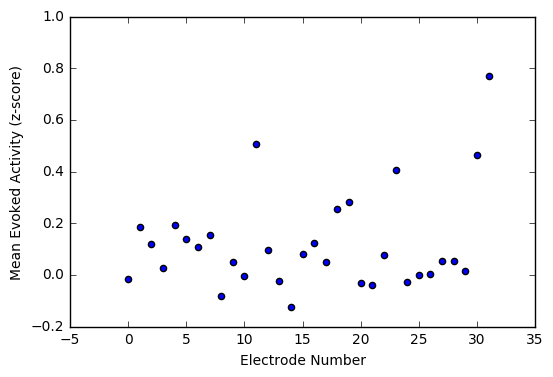

In [4]:
activity = ecog.copy()
_ = mne.baseline.rescale(activity._data, activity.times, (None, 0), mode='zscore', copy=False)
activity = activity._data.mean(0).mean(-1)
ix_active = np.argmax(activity)

fig, ax = plt.subplots()
ax.scatter(range(len(activity)), activity)
ax.set_xlabel('Electrode Number')
ax.set_ylabel('Mean Evoked Activity (z-score)')

In [5]:
# Finally, we'll mask for the times we want and concatenate across trials.
y = ecog._data[..., mask_time]
y = np.hstack(y).T

# Fitting encoding models with various features

Below we will fit a model with several feature representations (extracted in the Feature Extraction notebook). We'll visualize the coefficients of each.
## Speech Envelope
As a reminder, here's the average speech envelope across all sentences:

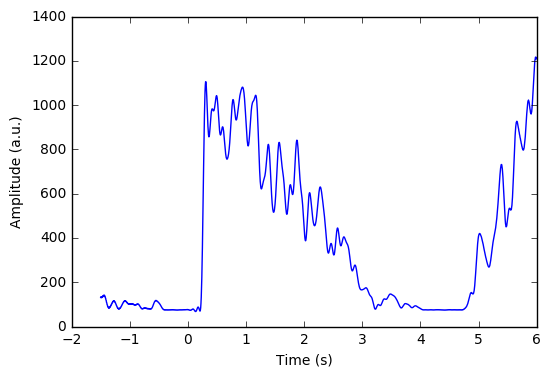

In [6]:
env = mne.read_epochs(feature_path + 'envelope-epo.fif')
fig, ax = plt.subplots()
ax.plot(env.times, env._data.mean(0).squeeze())
ax.set_xlabel('Time (s)')
ax.set_ylabel('Amplitude (a.u.)')

### Creating delayed features
When building encoding or decoding models, it is important to account for the fact that neural activity generally isn't responding to stimuli at the *exact* same moment in time. It takes some time for a neural signal to make its way to the brain area under study. Morever, it could be that a brain region cares about patterns of stimulus features as they change over time.

To account for these cases, we include time-lagged versions of each feature in the model fitting. In this case, we'll use delays from .1 seconds before, to .4 seconds after the stimulus. Note that this can quickly make our feature space grow quite large, so be careful when you choose how many lags to use.

In [7]:
# Define our time delays in seconds
delays = np.linspace(-.4, 0., 20)
X_delayed = delay_time_series(env._data, delays, env.info['sfreq'])

We can visualize these time-lagged features below. For the speech envelope this is straightforward since it is only a single feature. Note that each delay simply amounts to shifting the feature forwards or backwards in time.

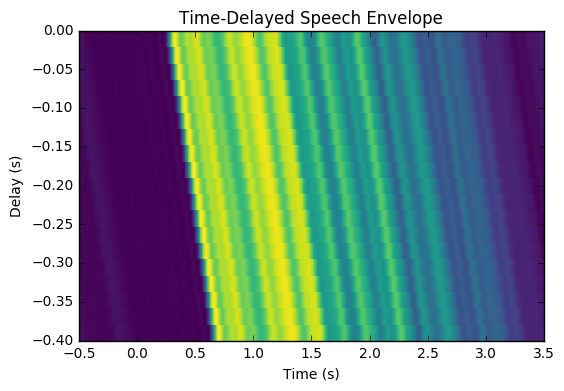

In [8]:
fig, ax = plt.subplots()
ax.pcolormesh(env.times[mask_time], delays,
              X_delayed.mean(0)[0][..., mask_time], cmap='viridis')
ax.axis('tight')
ax.set_ylabel('Delay (s)')
ax.set_xlabel('Time (s)')
ax.set_title('Time-Delayed Speech Envelope')

Now, we will combine this expanded feature set across epochs, and use it to fit the model.

In [9]:
X_env = X_delayed.reshape([X_delayed.shape[0], -1, X_delayed.shape[-1]])
X_env = X_env[..., mask_time]
X_env = np.hstack(X_env).T

In scikit-learn, it is possible to chain together multiple objects that operate on the model data. This makes it possible to perform several operations on data before fitting the model. Here we will use a `StandardScaler` object, that will normalize the data to 0 mean and unit variance before fitting the model.

In [10]:
# Fit the model
est = make_pipeline(StandardScaler(), Ridge(alpha=1e5))
est.fit(X_env, y[:, ix_active])

Pipeline(steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('ridge', Ridge(alpha=100000.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001))])

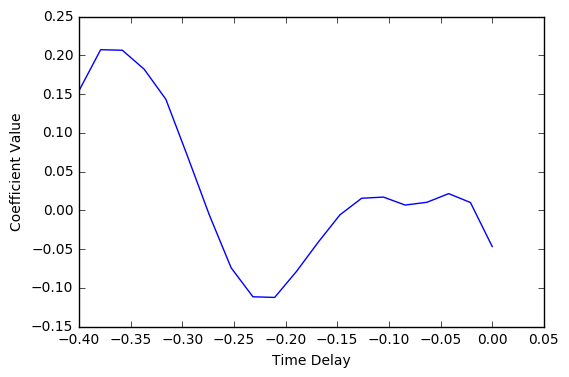

In [11]:
fig, ax = plt.subplots()
ax.plot(delays, est.steps[-1][-1].coef_)
ax.set_xlabel('Time Delay')
ax.set_ylabel('Coefficient Value')

By investigating the coefficients as they are spread across time lags, we can get an idea for the temporal profile of how this electrode responds to fluctuations in the speech envelope.

## Speech Spectrograms
Now we'll move to a slightly more complicated feature: spectrograms. This is inherently similar to the speech envelope, but it's got more features to begin with. However, the time delaying process is the same.

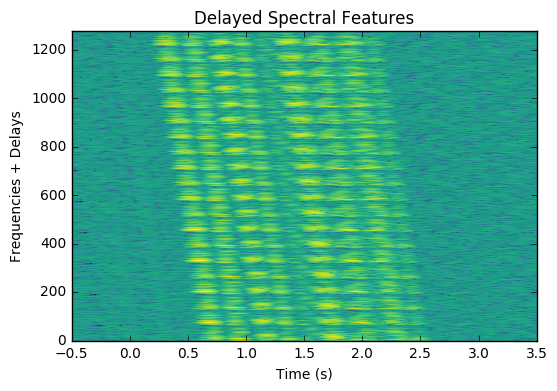

In [12]:
spec = mne.read_epochs(feature_path + 'spectrogram-epo.fif')
frequencies = np.array(spec.ch_names).astype(float)
X_delayed = delay_time_series(spec._data, delays, spec.info['sfreq'])

# We'll create two reshaped versions of the delayed data
# This one groups all features together for each delay (beffer for viz)
X_plt = X_delayed.swapaxes(1, 2).reshape(X_delayed.shape[0], -1, len(spec.times))
# This one groups all delays together for each feature (better for fitting)
X_delayed = X_delayed.reshape(X_delayed.shape[0], -1, len(spec.times))

# Now show the delayed features
fig, ax = plt.subplots()
ax.pcolormesh(spec.times[mask_time], np.arange(X_plt.shape[1]),
              np.log(X_plt)[0][..., mask_time], cmap='viridis')
ax.axis('tight')
ax.set_ylabel('Frequencies + Delays')
ax.set_xlabel('Time (s)')
ax.set_title('Delayed Spectral Features')

Now we'll stack the delayed spectral features across epochs, and fit the model.

In [13]:
# Model data
X_delayed = np.hstack(X_delayed[..., mask_time]).T

In [14]:
# We'll use a higher ridge parameter since we have so many more coefficients
est = make_pipeline(StandardScaler(), Ridge(alpha=1e7))
est.fit(X_delayed, y[:, ix_active])

Pipeline(steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('ridge', Ridge(alpha=10000000.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001))])

(-0.40000000000000002, 0.0, 2.4771212547196626, 3.9030899869919438)

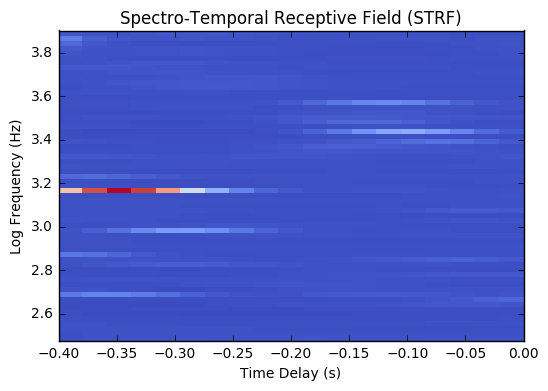

In [15]:
coefs = est._final_estimator.coef_
coefs = coefs.reshape(-1, len(delays))

f, ax = plt.subplots()
ax.pcolormesh(delays, np.log10(frequencies), coefs,
              cmap=plt.cm.coolwarm)
ax.set_xlabel('Time Delay (s)')
ax.set_ylabel('Log Frequency (Hz)')
ax.set_title('Spectro-Temporal Receptive Field (STRF)')
ax.axis('tight')

When we reshape the coefficients fit from a time-delayed spectrogram of sound, such that they are of shape `n_frequencies x n_delays`, we have a spectro-temporal receptive field. This describes the kinds of patterns in the spectrogram that will elicit an increase in activity for this electrode.

## Phonemes
Finally, we'll use the categorical (binary) variables corresponding to phoneme IDs. If you'll recall from the Feature Extraction notebook, these were created by constructing one variable per phoneme, filled mostly with `0`s, and with a `1` for any timepoint where that phoneme was present.

Here we'll read in the phonemes, and use them as inputs to a regression model predicting high-frequency activity.

In [16]:
phonemes = mne.read_epochs(feature_path + 'phonemes-epo.fif')
phonemes.drop_channels(['h#'])  # Drop silent times
X_delayed = delay_time_series(phonemes._data, delays, phonemes.info['sfreq'])
X_delayed = X_delayed.reshape(X_delayed.shape[0], -1, X_delayed.shape[-1])
X_delayed = np.hstack(X_delayed[..., mask_time]).T

In [17]:
# Now fit the model. We won't scale the inputs since they're binary
est = Ridge(alpha=1e5)
est.fit(X_delayed, y)

Ridge(alpha=100000.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

Even though this feature representation is quite different from the continuous variables of spectrograms, we interpret the weights in a similar fashion. Because these are binary variables, it means means that the presence of phoneme at a particular moment in time will result in a change in the output amplitude that is equal to the weight value.

If we look at the weights across phonemes for one channel, it seems that it cares more about some phonemes than others. In a sense, this tells us what phonemes the electrode is "tuned" for.

(-0.40000000000000002, 0.0, 0.0, 56.0)

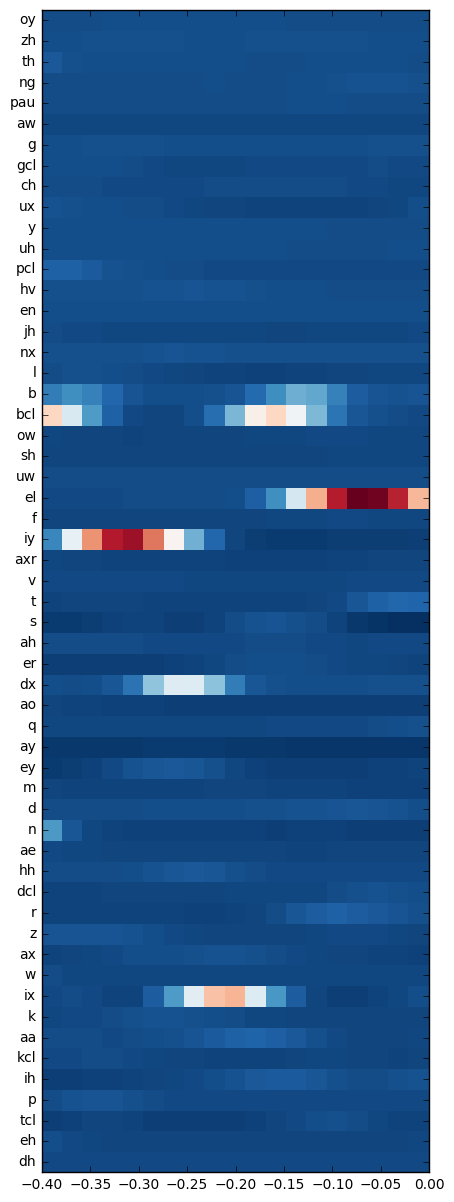

In [18]:
coefs = est.coef_
coefs = coefs.reshape(-1, len(phonemes.ch_names), len(delays))

f, ax = plt.subplots(figsize=(5, 15))
y_vals = np.arange(len(phonemes.ch_names))
ax.pcolormesh(delays, y_vals, coefs[ix_active],
              cmap=plt.cm.RdBu_r)
plt.yticks(y_vals + .5, np.array(phonemes.ch_names)[y_vals])
ax.axis('tight')

It should be noted that for all of these feature representations, we chose a (somewhat arbitrary) value for the regularization parameter. To determine the "correct" version of the parameter, we should have used cross-validation, which we'll cover in the final notebook.

# The effect of regularization
While we won't go into cross-validation here, we *can* investigate the effect that regularization has on the model coefficients. We'll turn back to regression with the speech envelope, since that's easy to model in 1-D. 

We'll fit the model using a range of alpha values (it is common to choose alpha values that are on the log-10 scale, but we'll choose many in between to show a smooth transition). Notice what happens:

In [19]:
def plot_model_coefficients(X, y, model, alphas, cmap=None):
    cmap = plt.cm.viridis if cmap is None else cmap
    name = model.__name__
    fig, ax1 = plt.subplots()
    im = ax1.imshow(np.atleast_2d(alphas), vmin=alphas.min(),
                   vmax=alphas.max(), cmap=cmap)
    ax1.set_xticks(range(len(alphas))[::2])
    ax1.set_xticklabels(['{:.4f}'.format(ia) for ia in alphas[::2]], rotation=45)
    ax1.set_title('{} Parameter Value'.format(name))

    
    # Fit the model with that value, then save the coefficients for viz
    coefs = np.zeros([alphas.shape[0], y.shape[-1], X.shape[-1]])
    for ii, alpha in enumerate(alphas):
        est = make_pipeline(StandardScaler(), Ridge(alpha=alpha))
        est.fit(X, y)
        coefs[ii, ...] = est.steps[-1][-1].coef_

    # Visualize the results
    fig, ax2 = plt.subplots()
    for ii, icoefs in enumerate(coefs[:, ix_active, :]):
        ax2.plot(delays, icoefs,
                color=cmap(float(ii) / coefs.shape[0]))
    ax2.set_xlabel('Time Lag (s)')
    ax2.set_ylabel('Coefficient Amplitude')
    ax2.set_title('Effect of {} regularization on coefficients'.format(name))
    return ax1, ax2

(<matplotlib.axes._subplots.AxesSubplot at 0x15495ea90>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1120ff910>)

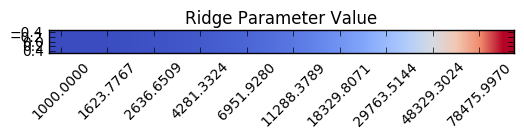

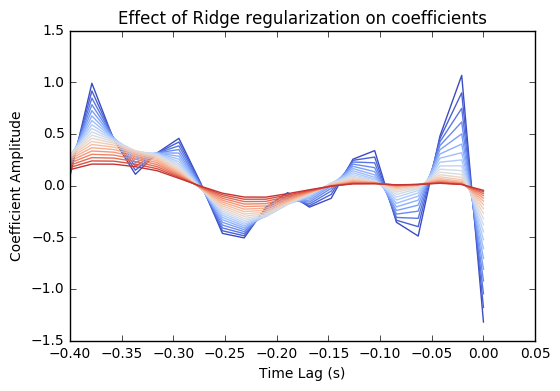

In [20]:
# Choose a range of values to fit
alphas = np.logspace(3, 5, 20)
plot_model_coefficients(X_env, y, Ridge, alphas, cmap=plt.cm.coolwarm)

As you may notice, increasing the size of the ridge parameter (moving from cool to hot colors) servs to both reduce the overall amplitude of the model coefficients, as well as smooth them somewhat. The result is a set of coefficients that is more stable and likely a better description of the true relationship between stimulus features and brain activity.

For comparison, we'll try the same thing with Lasso regression, which imposes a penalty that results in sparse coefficients (meaning that there are more coefficients that are very small / very large).

(<matplotlib.axes._subplots.AxesSubplot at 0x12013ed10>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1204aa4d0>)

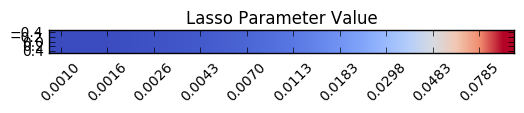

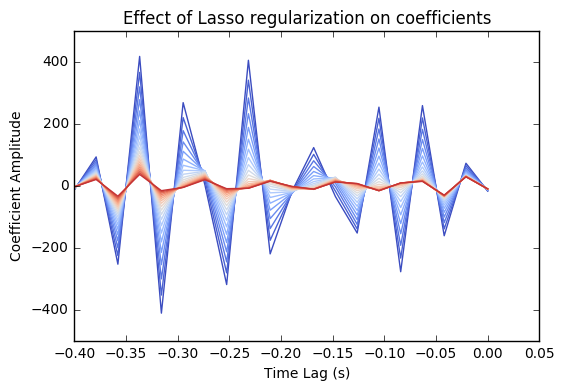

In [21]:
alphas = np.logspace(-3, -1, 20)
plot_model_coefficients(X_env, y, Lasso, alphas, cmap=plt.cm.coolwarm)

# Fitting Decoding Models
This notebook has thus far focused on the case of *encoding models*, in which stimulus features are used to predict patterns of neural activity. In the final two sections, we will discuss two cases of *decoding models*, in which neural features serve as input to a model that predicts properties in the world.

## Regression using spectrograms
We'll begin with *stimulus reconstruction*, a technique for predicting a single time-varying stimulus feature using joint activity across all ECoG electrodes. By fitting a reconstruction model for multiple stimulus features, we may combine them to form a single full stimulus representation.

We'll focus on the case of spectrograms, as they have been documented in the literature and raise interesting possibilities for techniques such as neuroprosthetics. The features will be largely the same as those used in encoding models above, but in this case the inputs and outputs are flipped.

We'll begin by creating delayed input features. In this case, these features are high-frequency amplitude of ECoG electrodes.

In [22]:
# Create delayed ECoG features
ecog_delayed = delay_time_series(ecog._data, delays, ecog.info['sfreq'])
X_ecog = ecog_delayed.reshape([ecog_delayed.shape[0], -1, ecog_delayed.shape[-1]])

# We'll use this subset of trials for model fitting
epoch_test = [12]
epochs_fit = np.setdiff1d(range(len(ecog)), epoch_test)
X_ecog_fit = np.hstack(X_ecog[epochs_fit][..., mask_time]).T
# And we'll predict using a held-out trial
X_ecog_predict = np.hstack(X_ecog[epoch_test]).T

Now we'll create our output features. These are spectral features of the speech stimulus, one frequency band per feature (and together, they make up the spectrogram).

In [23]:
# We'll take the log so that amplitude differences aren't as big
y_spec = np.log(np.hstack(spec._data[:-1][..., mask_time]).T)
y_predict = np.log(np.hstack(spec._data[-1][..., mask_time]).T)

Finally, we will use the same model that we used in encoding models (with flipped inputs and outputs). Note that the second argument in the call to `.fit` is now a *matrix* instead of a single 1-D vector. This is because `scikit-learn` allows you to fit multiple models at one time by passing a matrix in this fashion. We will get one set of coefficients per column of `y_spec`, corresponding to the decoding model for one feature.

In [24]:
# Fit the model
est = make_pipeline(StandardScaler(), Ridge(alpha=1e5))
est.fit(X_ecog_fit, y_spec)

Pipeline(steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('ridge', Ridge(alpha=100000.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001))])

Finally, we can now use this decoding model to make predictions about stimulus properties at each moment in time. Note that we've fit the model on `N-1` trials, and are now using it to predict the spectrogram of the held out trial. Note that the model is able to predict the times at which there is spectral content present, but the decoded spectrogram lacks some detail compared with the true speech spectrograms. If we wished to validate this model, we would correlate the predicted and true spectrograms with one another.

(-0.5, 3.5, 300.0, 8000.0)

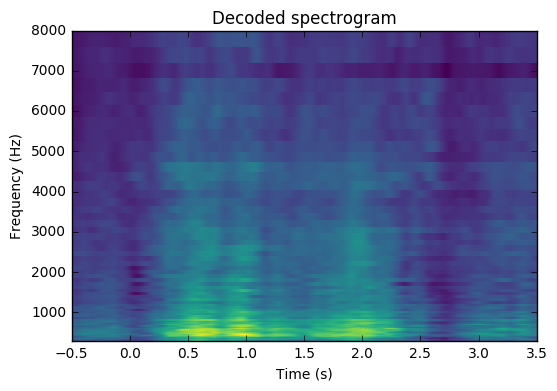

In [25]:
# Make predictions 
y_preds = est.predict(X_ecog_predict).T
freqs = np.array(spec.ch_names).astype(float)

f, ax = plt.subplots()
ax.pcolormesh(ecog.times[mask_time], freqs, y_preds[..., mask_time],
              cmap=plt.cm.viridis)
ax.set_title('Decoded spectrogram')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Frequency (Hz)')
ax.axis('tight')

Finally, it can be instructive to investigate the coefficients that were fit in the decoding model. This may give us an indication of which electrodes were most important in producing each prediction. This is a complicated business to interpret correctly (see manuscript for references on this), so we will stick visualizing them below and leaving it up to the reader to glean understanding from it.

Below we will show the coefficients for one frequency band. In this case, the coefficients have a natural shape `n_electrodes x n_delays`. Larger weights mean that an increase in amplitude for an electrode results in an increase in the predicted output amplitude for that frequency band.

(-0.40000000000000002, 0.0, 0.0, 31.0)

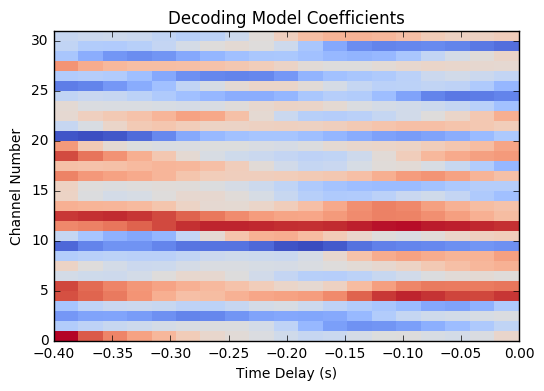

In [26]:
coefs = est._final_estimator.coef_
coefs = coefs.reshape(coefs.shape[0], -1, len(delays))
f, ax = plt.subplots()
ax.pcolormesh(delays, range(len(ecog.ch_names)), 
              coefs[12], cmap=plt.cm.coolwarm)
ax.set_xlabel('Time Delay (s)')
ax.set_ylabel('Channel Number')
ax.set_title('Decoding Model Coefficients')
ax.axis('tight')

## Visualizing decoding weights
While the above plot is useful, it's more informative to view the distribution of model coefficients on an actual brain. Here we have provided a tiny interactive viewer to scroll through the coefficients of each frequency band. We've plotted the rough location of each electrode on an artificial brain. The size and color of the electrode correspond to the model coefficient value for that frequency band.

Scroll through the results and see if particular electrodes seem to be more "important" than others in making predictions.

<function __main__.plot_fit>

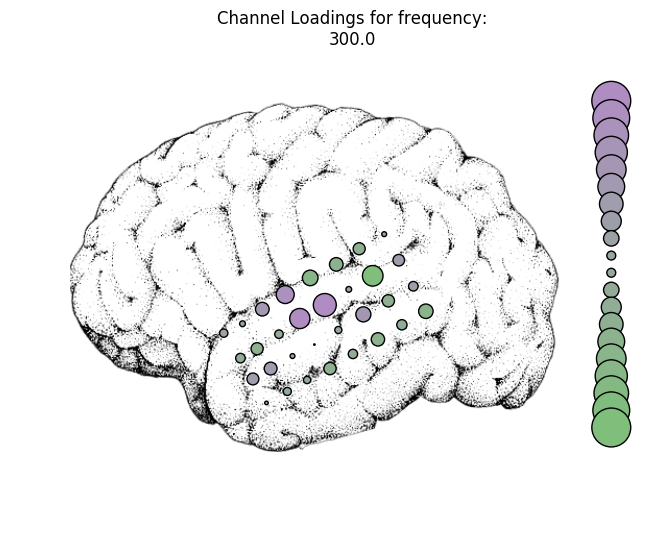

In [27]:
# Load electrode position data
elec_positions = pd.read_csv(raw_path + 'meta_elec.csv')
x_ch, y_ch = elec_positions[['x_2d', 'y_2d']].values.T
im = plt.imread(raw_path + 'brain.png')
cmap = modelingtools.cmap_activity

# A quick function to allow for interactive plotting
def plot_fit(ix_freq=0):
    channel_loading = coefs[ix_freq].mean(-1)
    channel_loading = scale(channel_loading)
    ax = plot_activity_on_brain(channel_loading, im, x_ch, y_ch,
                                size_scale=100, cmap=cmap, vmin=-2, vmax=2)
    ax.figure.set_size_inches(8, 8)
    ax.set_title('Channel Loadings for frequency:\n{}'.format(freqs[ix_freq]))
    ax.set_axis_off()
    
interact(plot_fit, ix_freq=[0, len(ecog.ch_names)])

# Decoding with classification
We will end this tutorial with a look at another method of performing decoding: classification. In this case, the model outputs a discrete variable as output (as opposed to a continuous, time-varying value in regression).

Because of the different nature of these outputs, we'll use a different set of data for constructing the model. We have created a feature set of evoked high-frequency activity in response to *each phoneme*. There are many more epochs in this case because there are many phonemes for every trial in the experiment.

We'll build a decoder that attempts to use evoked high-frequency activity to predict whether a phoneme is a fricative or not. When we have multiple classes, it is common to use a *one vs. all* decoding approach, that picks one target class to decode, and groups all other classes into a single opposing class for the purposes of the model. The model is intuitively asking whether it can distinguish the target class from all other possible classes.

*Note: We've pulled our mappings from phoneme label to phoneme class from [this paper]( http://www.intechopen.com/books/speech-technologies/phoneme-recognition-on-the-timit-database) on using the TIMIT dataset for machine learning*

In [28]:
# Load phoneme timing information
phonemes = mne.read_epochs(feature_path + 'ecog_phonemes-epo.fif')
phoneme_labels = pd.read_csv(raw_path + 'phoneme_labels.csv', index_col=0)
phoneme_labels = phoneme_labels.query('phoneme in @phonemes.event_id.keys()')

# Here we'll define the phoneme we wish to predict
target_ph = ['fricatives']
# We'll lump all other phoneme classes into a single 'non-target' class
non_target_ph = list(np.setdiff1d(phoneme_labels['kind'], target_ph))
phonemes_targets = phoneme_labels.query('kind in @target_ph')['phoneme'].values
phonemes_non_targets = phoneme_labels.query('kind in @non_target_ph')['phoneme'].values

Now, we'll construct the actual inputs/outputs for the model. As inputs we'll use the evoked high-frequency activity for all electrodes, one datapoint per phoneme presentation. As outputs we'll use a binary vector that encodes the presence of the target class (in this case, fricatives).

In [29]:
ecog_targets = phonemes[list(phonemes_targets)]._data.mean(-1)
ecog_non_targets = phonemes[list(phonemes_non_targets)]._data.mean(-1)

labels_targets = np.ones(ecog_targets.shape[0])
labels_non_targets = np.zeros(ecog_non_targets.shape[0])

# We'll scale the input variables (ECoG data) but not the binary outputs
X = scale(np.vstack([ecog_targets, ecog_non_targets]))
y = np.hstack([labels_targets, labels_non_targets])

Finally, we'll fit the model. We'll try this with two different classifier models. One that is linear, one that is non-linear.

First, we'll use a linear support vector machine. This is a classifier that attempts to find a set of linear coefficients that can reliable separate out the two classes, while also maximizing the "padding" that lies between the classifier boundary and the nearest examples of each class on either side.

*Note: we are skimming over some important details on classification for the sake of time. There are excellent resources on the internet for background and practical considerations with classifiers. We recommend the [scikit-learn documentation](http://scikit-learn.org/stable/tutorial/index.html) as a good start.*

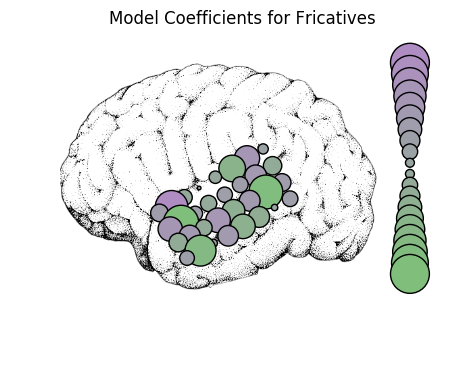

In [30]:
# Fit the model
svm = LinearSVC()
svm.fit(X, y)

ax = plot_activity_on_brain(svm.coef_[0], im, x_ch, y_ch, size_scale=5000,
                            cmap=modelingtools.cmap_activity)
ax.set_title('Model Coefficients for Fricatives')

Above we've plotted the model coefficients that the classifier found to be "important" in classifying fricatives vs. all other phoneme types. Again, interpreting the values of these coefficients relative to one another is complicated, so we urge readers to look at the literature for more information on this practice.

However, compare the model coefficients that were fit with this phoneme classifier to the reconstruction coefficients used to decode a spectrogram. Are the electrodes with high amplitudes the same, or different? Presumably, by using these different feature representations we are tapping into different steps of the sensory hierarchy in the brain.
